# Convolutional Neural Networks with Keras (1)

## CNN from scratch

We will train our CNN to distinguish ants and bees

https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

https://medium.com/towards-data-science/transfer-learning-using-keras-d804b2e04ef8

http://cs231n.github.io/transfer-learning/

http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html






http://forums.fast.ai/t/how-does-keras-resize-images/1743/9
    
    I would be also interested in that.
I really feel what I'd be looking into is something like that:
1. find the max height, width of the batch
2. set it as targeted size and fill it with 0
3. resize it to final size (224 x 224)
This would keep the ratio while allow dynamic sizes.
Sadly I am not really sure how to integrate that with flow_from_directory
i.e.
batch size = 4
(img1 3 x 1220 x 1200 , img2 3 x 1920 x 696, img3 3 x 550 x 550)
1. gives us 3 x 1920 x 1200
2. fill all the image with zeros such as they have this dims 3 x 1920 x 1200
3. reshape it the way flow_from_directory do it to go to 3 x 224 x 224

There might need a different behavior if the image is smaller than 224 x 244.

Looks like it's using PIL.Image.resize()

The dataset can be downloaded from

It uses the following directory structure:

In [38]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
import numpy as np
import os

In [37]:
#img_width, img_height = 150, 150

train_data_dir = 'data/train'
test_data_dir = 'data/test'
n_train = 246
n_test = 153
num_epochs = 50
batch_size = 16

In [65]:
heights = []
widths = []
import statistics

rootdir = './data'

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        path = (os.path.join(subdir, file))
        with Image.open(path) as img:
            width, height = img.size
            heights.append(height)
            widths.append(width)
            
print("heights(no./min/max/mean): {} / {} / {} / {}".format(
    len(heights), min(heights), max(heights), statistics.median(heights)))
print("widths(no./min/max/mean): {} / {} / {} / {}".format(
    len(widths), min(widths), max(widths), statistics.median(widths)))

heights(no./min/max/mean): 398 / 130 / 1984 / 375.0
widths(no./min/max/mean): 398 / 193 / 2592 / 500.0


In [55]:
?np.empty

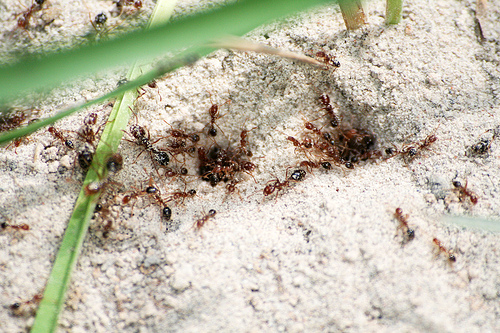

In [28]:
img = load_img('data/train/ants/1030023514_aad5c608f9.jpg')  
img

In [29]:
img_array = img_to_array(img)  
img_array.shape

(333, 500, 3)

In [30]:
K.image_data_format()

'channels_last'

In [31]:
img_array = np.expand_dims(img_array, axis=0)
img_array.shape

(1, 333, 500, 3)

### Data augmentation

In [32]:
# rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
# width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
# rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
# shear_range is for randomly applying shearing transformations
# zoom_range is for randomly zooming inside pictures
# horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry (e.g. real-world pictures).
# fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('data/train/cats/cat.0.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='cat', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [33]:
input_shape = (None, None, 3)

In [34]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
model.summary()


ValueError: The shape of the input to "Flatten" is not fully defined (got (None, None, 64). Make sure to pass a complete "input_shape" or "batch_input_shape" argument to the first layer in your model.

In [23]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
horizontal_flip=True)

In [24]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [25]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
class_mode='binary')

NameError: name 'img_width' is not defined

In [35]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
validation_steps=nb_validation_samples // batch_size)

NameError: name 'train_generator' is not defined

In [ ]:


model.save_weights('model_33_weights.h5') 
model.save('model_33_model.h5')



In [36]:
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img

test_model = load_model('model_33_model.h5')

for imgfile in os.listdir('data/test/crack'):
    print(imgfile)
    img = load_img('data/test/crack/' + imgfile,grayscale=True,target_size=(100,100))
    x = img_to_array(img)
    x = x/255
    x = np.expand_dims(x, axis=0)
    preds = test_model.predict_classes(x, verbose=0)
    probs = test_model.predict_proba(x, batch_size=1, verbose=0)
    print(preds, probs)

OSError: Unable to open file (Unable to open file: name = 'model_33_model.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)